In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

In [61]:
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

!pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


### Overview

Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

### Business Objectives

We are going to analysis the Customers based on below 3 factors:

R (Recency): Number of days since last purchase

F (Frequency): Number of transactions

M (Monetary): Total amount of transactions (revenue contributed)

This is with the aim to more effectively group customers for purposes such as marketing campaigns and customer engagement.

# Reading and understanding data

In [3]:
# Reading the data

data =  pd.read_excel('data/online_retail.xlsx', index_col=0)  

In [23]:
# Copying to a dummy variable

df = data.copy()

In [24]:
# Examining the head of the data

df.head()

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
InvoiceNo,,,,,,,
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [25]:
# Examining the shape of the data 

df.shape

(541909, 7)

In [26]:
# Describing the data to understand outliers

df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Cleansing

In [27]:
# Including CustomerID as a feature not the index

df.reset_index(inplace = True)

In [28]:
# Understandin how many nulls there are

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [29]:
# What proportion of our features are nulls

df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [30]:
# Removing these null values

df = df.dropna()

In [31]:
# Changing InvoiceNO to string as it has entries with letters

df = df.astype({'InvoiceNo':str})

# Data Preperation

In [32]:
# Creating new features of Recency, MonetaryValue and converting InvoiceDate to datetime

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["OrderValue"] = df["Quantity"] * df["UnitPrice"]
last_date = max(df['InvoiceDate']) + datetime.timedelta(days=1)

In [33]:
# First we group by invoice data so that each invoice is only counted once

invoices = df.groupby(['InvoiceNo']).agg({'OrderValue': 'sum',
                                       'InvoiceDate': lambda x: (last_date - x.max()).days,
                                       'CustomerID' : 'mean'})

In [34]:
# Including invoices in the features again

invoices.reset_index(inplace=True)

In [36]:
# Examining invoices

invoices.head()

,InvoiceNo,OrderValue,InvoiceDate,CustomerID
0,536365,139.12,374,17850.0
1,536366,22.20,374,17850.0
2,536367,278.73,374,13047.0
3,536368,70.05,374,13047.0
4,536369,17.85,374,13047.0


In [42]:
# Removing the doubling effect from cancelled orders - cancelling them out with their original order values. 
# This happens automatically with their value as it appears negative

def frequency_func(series):
    result = 0 
    unique_numbers = list(set([i for i in series]))
    for number in unique_numbers:
        if number[0] == 'C':
            result += -1
        else:
            result += 1
    return result

In [64]:
# Grouping by customer to get final results for Recency, Frequency and MonetaryValue

customers = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (last_date - x.max()).days,
                                            'InvoiceNo': frequency_func,
                                            'OrderValue': 'sum'})

In [65]:
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'OrderValue': 'MonetaryValue'}, inplace=True)

In [66]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,0,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [67]:
# Removing all customers who have 0 frequency or monetary value - these have appeared due to cancelled orders

customers = customers[customers['Frequency'] != 0]

In [68]:
# Down to 4114 customers

customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4114 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4114 non-null   int64  
 1   Frequency      4114 non-null   int64  
 2   MonetaryValue  4114 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 128.6 KB


## Outlier Analysis

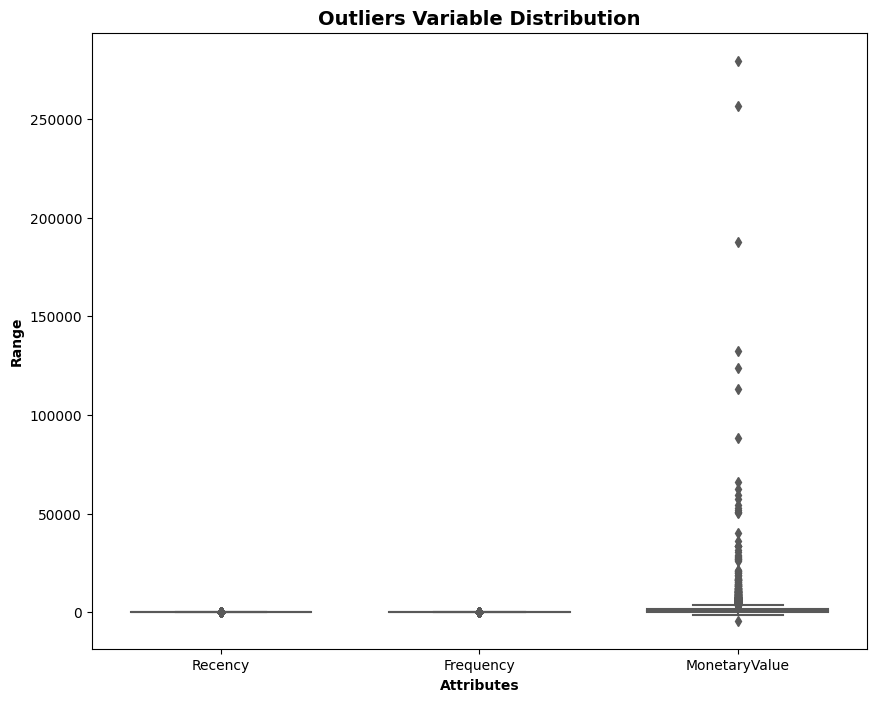

In [69]:
# K-Means is very sensitive to outliers (as it is centred on the mean) so we need to be careful before modelling

attributes = customers.columns
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = customers[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [70]:
# Clearly we have an issue with the outliers for MonetaryValue which heavily affect K-Means clustering. 
# We will remove statistical outliers to account for this and adjust the data.

# Removing (statistical) outliers for Amount
Q1 = customers['MonetaryValue'].quantile(0.05)
Q3 = customers['MonetaryValue'].quantile(0.95)
IQR = Q3 - Q1
customers = customers[(customers['MonetaryValue'] >= Q1 - 1.5*IQR) & (customers['MonetaryValue'] <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = customers['Recency'].quantile(0.05)
Q3 = customers['Recency'].quantile(0.95)
IQR = Q3 - Q1
customers = customers[(customers['Recency'] >= Q1 - 1.5*IQR) & (customers['Recency'] <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = customers['Frequency'].quantile(0.05)
Q3 = customers['Frequency'].quantile(0.95)
IQR = Q3 - Q1
customers = customers[(customers['Frequency'] >= Q1 - 1.5*IQR) & (customers['Frequency'] <= Q3 + 1.5*IQR)]

## Rescaling the data

In [71]:
ss = StandardScaler()
customers_scaled = pd.DataFrame(ss.fit_transform(customers), columns = customers.columns)

In [72]:
customers_scaled.head()

,Recency,Frequency,MonetaryValue
0,-0.889050,1.221721,1.643529
1,-0.157114,0.287632,0.261211
2,-0.718599,-0.646458,0.239377
3,2.199116,-0.646458,-0.543526
4,-0.548148,0.598995,0.122674


# Building the model

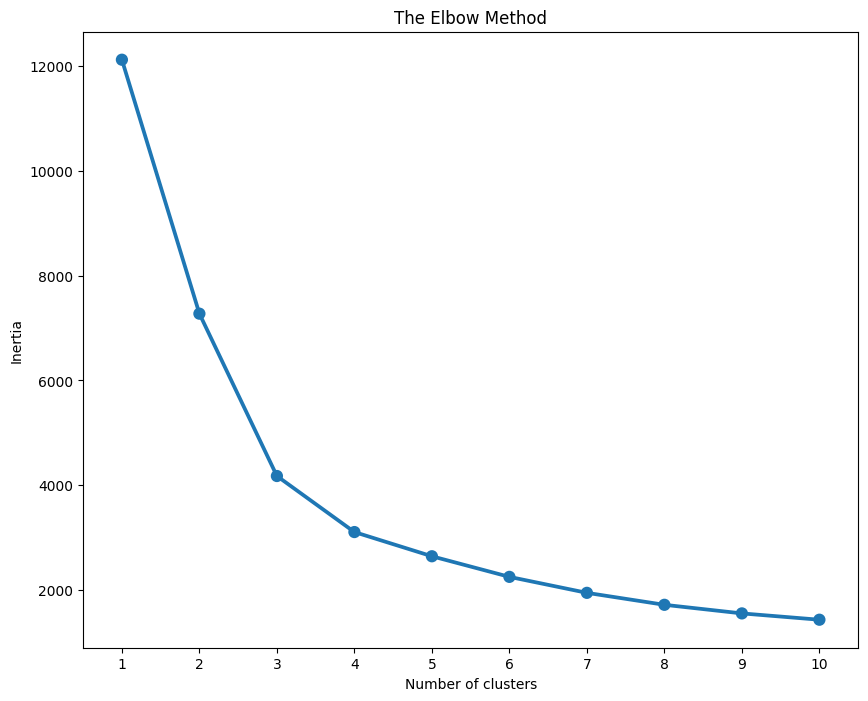

In [74]:
# Iterate K-means through clusters of size 1-11 and understand which leaves the smallest loss function (inertia)

inertias = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(customers_scaled)
    inertias[k] = kmeans.inertia_ # SSE to closest cluster centroid

#Elbow Plot    
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
sns.pointplot(x=list(inertias.keys()), y=list(inertias.values()))
plt.show()

In [75]:
# By the Elbow Method 3 seems to be a good choice for clustering

model = KMeans(n_clusters=3, random_state=42).fit(customers_scaled)

customers["Cluster"] = model.labels_


# Interpreting model results

In [82]:
# we see that the models are relatively uneven in the following split (1:2:5)

customers['Cluster'].value_counts()

0    2638
2     970
1     433
Name: Cluster, dtype: int64

In [83]:
# Cluster significance

customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         44.20      2.60       1016.42  2638
1         21.27     10.01       5269.51   433
2        248.04      1.27        392.63   970

In [ ]:
# We clearly see that cluster 2 are old customers, with low purchasing value and frequency.
# Cluster 1 is the most valueable cluster by far, with a lifetime value of over £5,000, combined with the highest frequency
# and most regular purchases
# Cluster 0 are the marginal customers who sit in the middle of the others, which is why they are over represented